### Audio Classification in Pytorch
This notebook describes the steps taken in realizing a Convolutional Neural Network (CNN), usable for audio classification tasks. The goal is to research the use of CNNs in audio classification and how to go about preprocessing audio data to make it useful for training a model. 

#### 1. Introduction
This assignment aims to solve the following problem:

"The company SLIFTS (Smart Lifts in Floor Transition Systems) want to expand its elevator capabilities to handle spoken commands. In the aftermath of the global 2020 COVID pandemic, the company has noted a sharp decline in the number of passengers that use their elevators. Marketing research has shown that people are hesitant to touch physical buttons in the elevator. As one user noted “this up-button looks really yucky, I can almost see the germs crawling on it!”. The situation is extremely serious and people are even doing previously unthinkable things like taking the stairs, which has to be prevented in all cases. To resolve this problem, SLIFTS has hired Zuyd Hogeschool to research and develop elevators with voice command capabilities."

To solve this problem, the following points will be looked at closely:
1. Preprocessing audio data for training a CNN.
2. Preparing the dataset for training.
3. Designing the model.
4. Implementing the model for training.
5. Evaluating the output of the model after training.

Note that the advise and conclusion are included in a separate document (see "AdvisoryReport.pdf). This document will describe the findings about the innerworkings of Neural Networks for the task at hand.

#### 2. Data Collection
For any machine learning/AI project, a dataset is needed to train, test and evaluate a model once it's built in code. In the case of recognizing speech commands, a dataset is needed where these speech commands, like 'yes' or 'down', need to be made audible. Fortunately, such a dataset is already available on [Kaggle](https://www.kaggle.com/datasets/antfilatov/mini-speech-commands/data). For the assignment, this dataset will be the only dataset used. For advise on improving the dataset, see the advisory report.

This dataset includes the following 8 commands: down, go, left, no, right, stop, up, yes.

In the code below, a class is made for initializing a dataset. For a custom dataset in pytorch, the class msut be inherited from <code>torch.utils.data.Dataset</code>, where the class implements the following methods:
- <code>__init__</code>: init initializes the dataset. Since this is a folder based structure, files are loaded from the folder and labels are appended based on folder names. This is made easy with the use of <code>os</code> import.
- <code>__len__</code>: this method will return the labels and file names, appended to <code>file_paths</code>
- <code>__getitem__</code>: this method gets a waveform and returns it as a tensor. Also, it will either pad or truncate a waveform, to ensure that all waveforms have the same lengths. This is important for training the model, since the model expects all tensors to be of equal size. The waveforms are padded zeroes and the waveforms are converted from stereo to mono, to reduce the dimension size of the training data.

In [118]:
'''To make a custom dataset, a class will be made that inherits its properties
from the pytorch dataset class'''
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio
from torch import nn
import torch
import torch.nn as nn
import torchaudio.transforms as T

class LiftCommandDataset(Dataset):
    def __init__(self, root_dir: str, transform=None, target_len: int = 16000):
        self.root_dir = root_dir
        self.file_paths = []
        self.labels = []
        self.label_map = {}
        self.transform = transform
        self.target_len = target_len

        '''Recursively load all files and append corresponding labels from folder name'''
        '''Please optimize :('''
        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                self.label_map[label] = len(self.label_map)
                for file_name in os.listdir(label_dir):
                    if file_name.endswith('.wav'):
                        self.file_paths.append(os.path.join(label_dir, file_name))
                        self.labels.append(self.label_map[label])
        print("Label Map:", self.label_map, "\n")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index: int):
        file_path = self.file_paths[index]
        '''torchaudio.load() is important for turning waveforms into Tensors'''
        waveform, sample_rate = torchaudio.load(file_path)
        
        '''Convert stereo to mono if necessary'''
        if waveform.shape[0] == 2:  
            waveform = waveform.mean(dim=0, keepdim=True)

        waveform = self._pad_or_truncate(waveform)

        '''If transform is true (model parameter), like making a spectrogram, perform it here'''
        if self.transform:
            waveform = self.transform(waveform)
        
        label = self.labels[index]

        '''CrossEntropyLoss requires LongTensor for Label'''
        return waveform, torch.tensor(label, dtype=torch.long)
    
    def _pad_or_truncate(self, waveform):
        num_samples = waveform.shape[1]
        '''Truncate if sample is larger than target length, pad if sample is smaller than target length'''
        if num_samples > self.target_len:
            waveform = waveform[:, :self.target_len]
            #print("Debug: sample > target len")
            
        elif num_samples < self.target_len:
            pad_amount = self.target_len - num_samples
            waveform = torch.nn.functional.pad(waveform, (0, pad_amount))
            #print("Debug: sample < target len")
        
        return waveform

#### 3. Data Preprocessing


To make audio file formats usable for training a CNN, they will need to be converted to an image of some sort. For the given problem, there are two options to achieve this:
1. Mel-spectrogram: full time-frequency representation of an audio signal
2. Mel-frequency Cepstral Coefficients (MFCC): reduced set of coefficients from a waveform that summarize the spectral characteristics.

Both frequencies make use of the Mel scale, which is a scale of the pitches that approximately represent the way humans perceive sound. The Mel-spectrogram however captures a full time-frequency representation of the audio signal, while Mel-frequency only captures the most important characteristics of the audio signal.

For this project, Mel-spectrogram will be used since it might give the model more opportunities to understand underlying patterns.

In [119]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

In the code below, an example is taken from the dataset to show what the intermediate representations of the waveforms will look like during training. In the first snippet, output is given for a regular <code>*.wav</code> waveform, like sample rate, shape of the waveform and what it would look like as a tensor. 

In [120]:
waveform, sample_rate = torchaudio.load("./mini_speech_commands/down/0a9f9af7_nohash_0.wav")

print_stats(waveform, sample_rate=sample_rate)

Sample Rate: 16000
Shape: (1, 13654)
Dtype: torch.float32
 - Max:      0.115
 - Min:     -0.225
 - Mean:     0.003
 - Std Dev:  0.030

tensor([[0.0018, 0.0030, 0.0028,  ..., 0.0253, 0.0297, 0.0178]])



In [121]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

Below is the waveform when plotted using matplotlib.

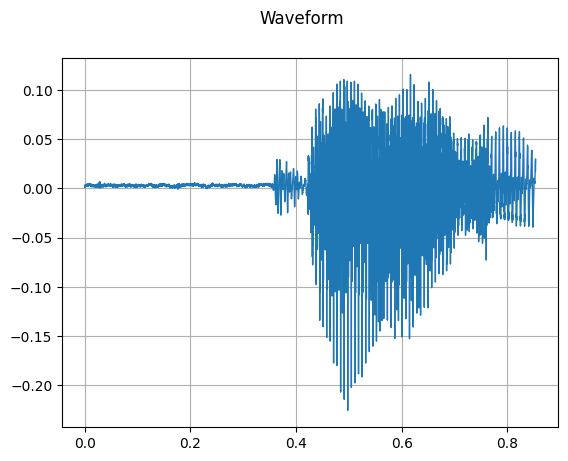

In [122]:
plot_waveform(waveform, sample_rate)

In [123]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

Below is the product of turning the waveform into a spectrogram. During training, the spectrograms will be slightly deformed by applying frequency and time masking. This is done to introduce more variation into the training set, in an effort to make the model more resilient to noise and overfitting, since the dataset only includes very clean audio simples with no background noise.

Time and frequency masking can also act as a form of regularization. By introducing variability in the training data, the model is less likely to memorize the training examples and more likely to learn meaningful patterns.

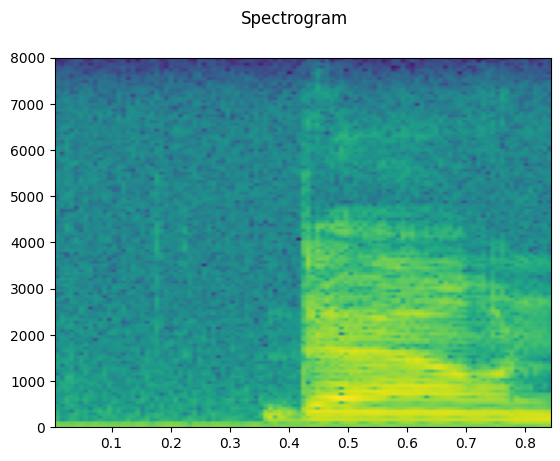

In [124]:
plot_specgram(waveform, sample_rate)

Below is an example of frequency and time masking when applied to a spectrogram. Note how the image is greyscaled to decrease the dimensions needed for the model to train on.


![Example of frequency and time masking](img/output.png)


In [125]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

The audio file in question:

In [126]:
play_audio(waveform, sample_rate)

The code below shows the implementation of a function that converts a waveform to a spectrogram and applies frequency and time masking to the spectrogram. This is also called augmentation. AmplitudeToDB turns a spectrogram from the power/amplitude scale to the decibel scale.

To make testing and validating more representative to what the given dataset originally looked like, augmentation is only applied to the testing dataset.

In [127]:
def apply_transforms(waveform):
    transforms = [
        T.MelSpectrogram(sample_rate=16000, n_mels=64, n_fft=400, hop_length=160),
        T.AmplitudeToDB(),
    ]
    
    for t in transforms:
        waveform = t(waveform)  # Apply each transform sequentially
    
    return waveform

In [128]:
def transform_augmentation(waveform):
    transforms = [
        T.MelSpectrogram(sample_rate=16000, n_mels=64, n_fft=400, hop_length=160),
        T.AmplitudeToDB(),
        T.FrequencyMasking(freq_mask_param=4),
        T.TimeMasking(time_mask_param=4)
    ]

    for t in transforms:
        waveform = t(waveform)
    
    return waveform

In [129]:
root_dir = './mini_speech_commands'

'''The dataset gets loaded in with transformations from above applied'''
dataset = LiftCommandDataset(root_dir, transform=None)

Label Map: {'down': 0, 'go': 1, 'up': 2, 'yes': 3, 'stop': 4, 'left': 5, 'no': 6, 'right': 7} 



An important component of ML/AI task is creating a separate test and validation dataset.

- The training set is used for training the model. It is this dataset that the model uses to (hopefully) learn the underlying patterns present in the data.
- The testing set is used to evaluate the final performance of the model after it has finished training.
- The validation set is used to measure the performance during training. This is helpful for evaluating at which points the model improves and it can tell more about if the model is overfitting (learning the data instead of the underlying patterns) and if hyperparameters need to be adjusted.

In [130]:
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.5, 0.25, 0.25])

In [131]:
train_dataset.dataset.transform = transform_augmentation
test_dataset.dataset.transform = apply_transforms
val_dataset.dataset.transform = apply_transforms

In [132]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)

In [133]:
for batch_waveforms in train_loader:
    print(batch_waveforms)

[tensor([[[[ -31.1561,  -12.9792,  -16.2882,  ..., -100.0000, -100.0000,
           -100.0000],
          [ -19.0734,  -12.7197,  -16.6890,  ..., -100.0000, -100.0000,
           -100.0000],
          [ -13.5777,  -12.3425,  -18.4969,  ..., -100.0000, -100.0000,
           -100.0000],
          ...,
          [ -41.3436,  -59.0021,  -61.4070,  ..., -100.0000, -100.0000,
           -100.0000],
          [ -41.4794,  -61.1307,  -70.0151,  ..., -100.0000, -100.0000,
           -100.0000],
          [ -41.4817,  -61.2028,  -69.2901,  ..., -100.0000, -100.0000,
           -100.0000]]],


        [[[ -34.2596,  -38.6290,  -38.4496,  ...,  -36.3986,  -36.1312,
            -34.1604],
          [ -33.4984,  -38.6648,  -37.3454,  ...,  -36.7047,  -34.8210,
            -34.1897],
          [ -32.1081,  -39.0938,  -35.4280,  ...,  -38.0988,  -32.6326,
            -34.5984],
          ...,
          [ -54.8322,  -56.8440,  -55.7903,  ...,  -49.1205,  -52.2643,
            -54.0176],
          [ -55

In [134]:
len(dataset)

8000

#### 5. Model Design

Below is an implementation of a CNN in pytorch. It consists of the following:
- 4 layers including the following steps:
    - Convolution: by applying convolution operations on input data, the model is able to learn spatial hierarchies of features. This is achieved with the kernel method, where the kernel "slides" over an image (steps are defined by stride), performing element-wise multiplication and summing the results to a feature map.

    - Batch Normalization: this normalizes the output of the previous layer by adjusting and scaling the activations. During training, this seemed to stabilize loss during training.

    - ReLU activation: this function introduces non-linearity to the model, making it able to learn complex patterns. It improves efficient computation and speed of convergence during training. 

    - Max pool: reduces the spatial dimensions of the feature maps, by retaining only the most important features while reducing computational complexity. This reduces the number of dimensions and computations in the neural network.

    - Dropout: regularization technique used to prevent overfitting by randomly setting part of the neurons to zero during training. This reduces overfitting by preventing the model from becoming too reliant on any single neuron.

- Flatten layer: the flatten layer converts the multi-dimensional output from the convolutional layers into a one-dimensional vector, making it able to convert the input into fully connected linear layers.

- Linear layer: used to make predictions over the category labels. This allows the model to learn complex relationships between the features from convolutional layers and target labels. The number of output neurons is usually equal to the number of classes.


In [ ]:
cnn = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(p=0.3),   

    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(p=0.3),  

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=2),
    nn.BatchNorm2d(64),    
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(p=0.3),  

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=2),
    nn.BatchNorm2d(128),    
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(p=0.4),  

    nn.Flatten(),
    nn.Linear(128 * 5 * 8, 8),
    
    #'''EntropyLoss already incorporates Softmax, making Softmax redundant'''
    #nn.Softmax(dim=1)
    ).to(device)

#### 6. Training and Evaluation
For this section, the model will be trained and its output will be examined.

In [136]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cuda


The learning rate defines the rate at which the model learns. Epochs define the number of iterations that the model takes to learn.

In [137]:
'''Setting up constants/hyperparameters'''
LEARNING_RATE = 0.0008
EPOCHS = 30

In [138]:
train_history = []
val_history = []

Below, the options used for the optimizer, loss function and scheduler are defined, including hyperparameters.

For the optimizer, Adam is chosen with a defined weight decay. The purpose of an optimizer is to update the models' weights during training to minimize the loss function. Adam (Adaptive Moment Estimation) is one of the more common optimization algorithms. Adam combines two different versions of Stochastic Gradient Descent (SGD): AdaGrad and RMSProp.

Adam computes individual adaptive learning rates for each parameter based on the first and second moments of the gradients. This means that parameters with larger gradients will have their learning rates reduced, while those with smaller gradients will have their learning rates increased. Adam also uses momentum to accelerate the optimization process. It can also lead to faster convergence.
For the following parameters for Adam:
- <code>lr</code>: this is the learning rate, which controls how much the model parameters are changed in response to the error each time the model weights are updated.
- <code>weight_decay</code>: this parameter applies L2 regularization to the weights of the model. This helps prevent overfitting by penalizing larger weights.


For the criterion (loss function), cross entropy is chose. The loss function measures how correct the model is in its prediction during classification, being a marker for how well the model is performing. Cross entropy is useful for multiclass classification, it also combines softmax activation, which converts raw scores (logits) into probabilities.

The scheduler adjusts the learning rate during training based on the performance of the model on the validation set. ReduceLROnPlateau reduces the learning rate when the validation loss has stopped improving. It includes the following parameters:

- <code>mode</code>: this parameter is set to 'min', meaning the scheduler will look for a minimum in the validation loss to determine when to reduce the learning rate.

- <code>factor</code>: this parameter determines how much to reduce the learning rate. For example, if the current learning rate is 0.001 and the factor is 0.3, the new learning rate will be 0.0003.

- <code>patience</code>: this parameter specifies how many epochs to wait for an improvement before reducing the learning rate.

In [139]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3)

Below is the code for iterating over epochs while running the model. It predicts loss and applies optimization. For the validation step, the scheduler is also used to detect if the loss for validation is plateauing. It also includes code for plotting the loss rate for both training and validation.

epoch: 0	train loss: 2.2277	val loss: 1.8124
epoch: 1	train loss: 1.6871	val loss: 1.7296
epoch: 2	train loss: 1.5095	val loss: 1.4450
epoch: 3	train loss: 1.3782	val loss: 1.2943
epoch: 4	train loss: 1.2314	val loss: 1.2044
epoch: 5	train loss: 1.0587	val loss: 0.9893
epoch: 6	train loss: 0.9487	val loss: 0.9206
epoch: 7	train loss: 0.8431	val loss: 0.8295
epoch: 8	train loss: 0.7638	val loss: 0.7408
epoch: 9	train loss: 0.6810	val loss: 0.7160
epoch: 10	train loss: 0.6679	val loss: 0.6697
epoch: 11	train loss: 0.6146	val loss: 0.6363
epoch: 12	train loss: 0.5603	val loss: 0.6039
epoch: 13	train loss: 0.5227	val loss: 0.5357
epoch: 14	train loss: 0.5073	val loss: 0.5864
epoch: 15	train loss: 0.4772	val loss: 0.5181
epoch: 16	train loss: 0.4476	val loss: 0.5111
epoch: 17	train loss: 0.4463	val loss: 0.5121
epoch: 18	train loss: 0.4222	val loss: 0.5096
epoch: 19	train loss: 0.4005	val loss: 0.4664
epoch: 20	train loss: 0.3903	val loss: 0.4592
epoch: 21	train loss: 0.3788	val loss: 0.474

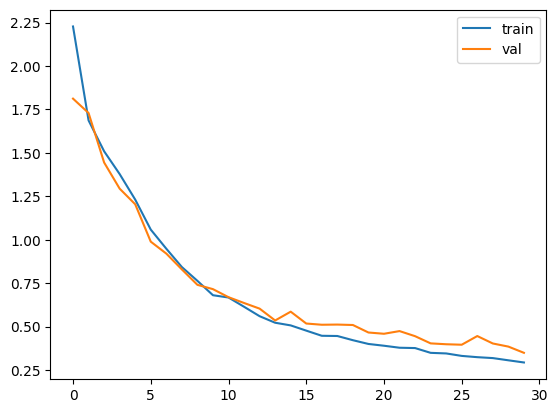

In [ ]:
for e in range(EPOCHS):
    batch_history = []

    for images, labels in train_loader:
        '''Convert images to the correct device (GPU or CPU)'''
        images, labels = images.to(device), labels.to(device)
         
        '''predict and compute loss'''
        preds = cnn(images)
        loss = criterion(preds, labels)
        batch_history.append(loss.item())

        '''Apply optimization'''
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    train_history.append(np.mean(batch_history))

    batch_history = []
    '''Validation step'''
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            preds = cnn(images)
            loss = criterion(preds, labels)
            batch_history.append(loss.item())
        val_history.append(np.mean(batch_history))
    
    '''Apply scheduler'''
    scheduler.step(val_history[-1])

    print(f"epoch: {e}\ttrain loss: {train_history[-1]:.4f}\tval loss: {val_history[-1]:.4f}")

plt.plot(train_history, label='train')
plt.plot(val_history, label='val')
plt.legend()

In [141]:
with torch.no_grad():
    test_loss = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        preds = cnn(images)
        loss = criterion(preds, labels)
        test_loss += loss.item()
    print(f"test loss: {test_loss / len(test_loader)}")

test loss: 0.380759596824646


In the output above, it can be noted that the model somewhat steadily improves over the epochs, since the loss rate is decreasing for both the training and validation data. With cross entropy loss, the closer the value is to zero, the better it may perform, with zero being perfect classification. 

The loss for training seems to decline faster that the loss during validation between 10-15 epochs, indicating the the model has slight issues with overfitting. However, the gap between the two outputs never grow very far, meaning that the model is generalizing the data well. It should be noted that running up to 30 epochs is not necessary, and stoping between 10-15 epochs would be ideal.

It can also be seen that the curve for validation is not completely stable. This could be a result of the scheduler kicking in when it runs out of patience.

Below is an overview of the representation of intermediate steps that the model takes during training, where a test image is processed in the layers of the CNN.

In [143]:
features = {} #dictionary that will store results!

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

hook_handles = []

In [144]:
for i, m in enumerate(cnn.children()):
    h = m.register_forward_hook(get_features(f"{i}{type(m).__name__}"))
    hook_handles.append(h)

Below is the model in action. This test data, that does not have any augmentation for keeping testing and validating representative to the original data, will be predicted by the model with the output being mapped to the actual class.

The actual label shows what type of command the waveform represents. Below shows the label it predicted, with a range of confidence scores.

Actual Label: no


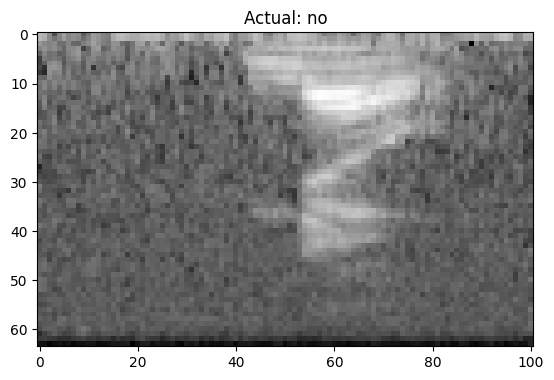

Predicted Label: no


{'down': -0.7444312572479248,
 'go': 2.2810699939727783,
 'up': -6.42336893081665,
 'yes': 1.033492922782898,
 'stop': -1.8697439432144165,
 'left': -2.399585485458374,
 'no': 5.627201557159424,
 'right': -5.050562858581543}

In [ ]:
idx = 59

image_sample, actual_label = test_dataset[idx]

class_mapping = ['down', 'go', 'up', 'yes', 'stop', 'left', 'no', 'right']
actual_class_name = class_mapping[actual_label]

y_pred = cnn(image_sample[None, :].to(device))

y_mapping = {class_mapping[i]: yi.item() for i, yi in enumerate(y_pred.cpu()[0])}

plt.imshow(image_sample.squeeze(), cmap='gray')
plt.title(f"Actual label: {actual_class_name}")
plt.show()

predicted_label = torch.argmax(y_pred).item()
predicted_class_name = class_mapping[predicted_label]

print(f"Predicted Label: {predicted_class_name}")

y_mapping

Below is the entire CNN shown in action, with all the intermediate representations to a given spectrogram, flatten layer and output predictions in the linear layer.

/tmp/ipykernel_6382/1173456775.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(30, 5))


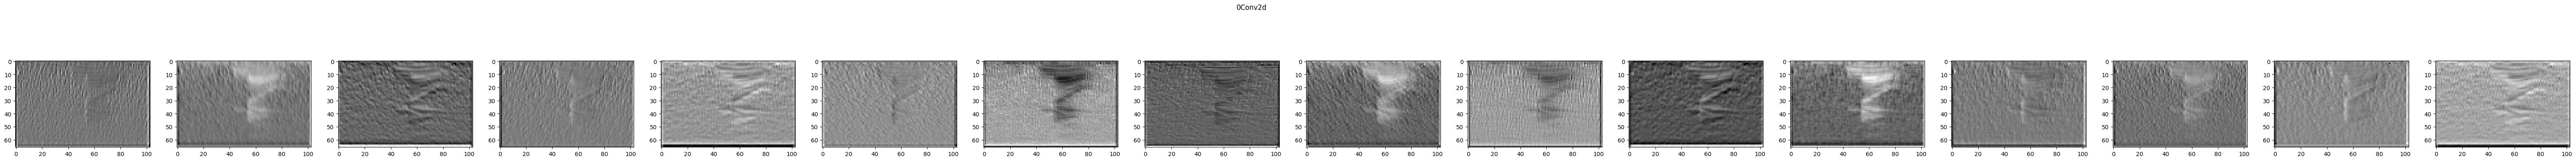

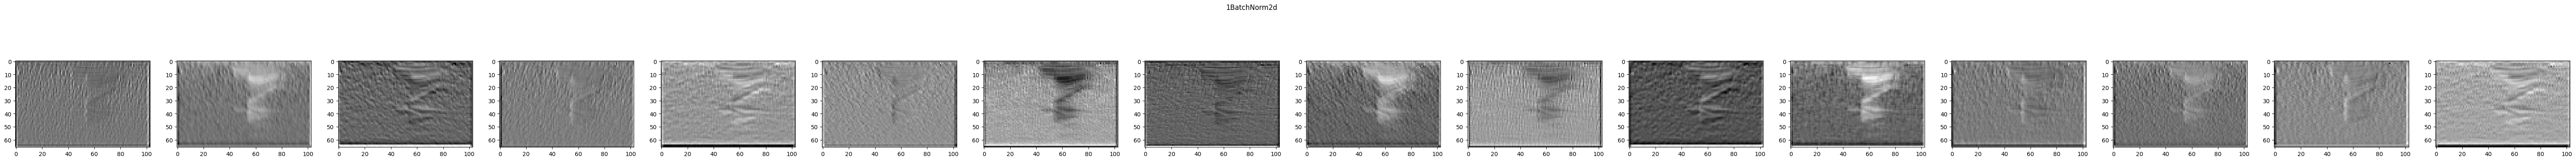

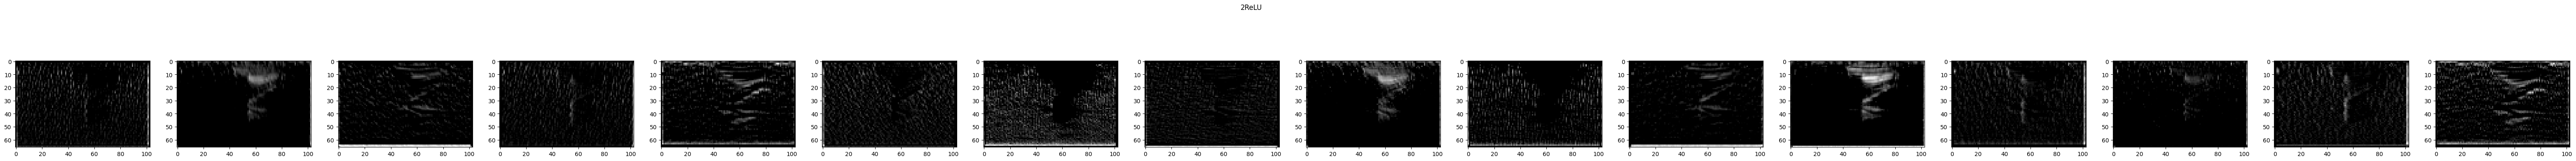

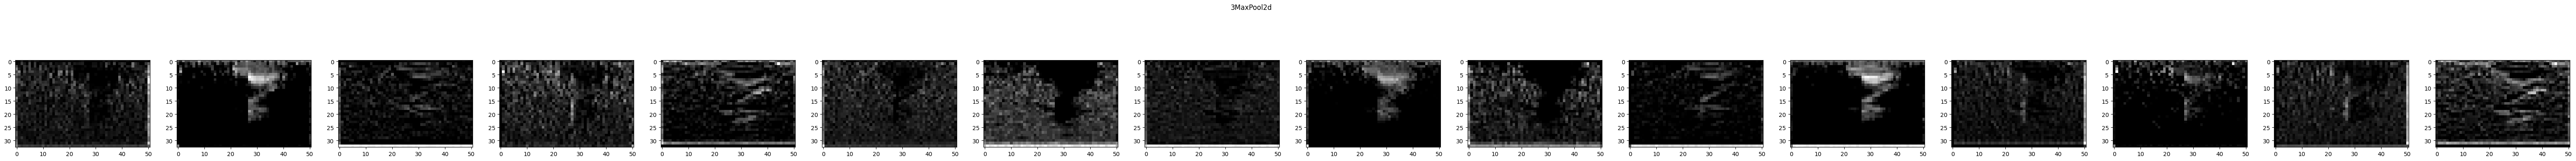

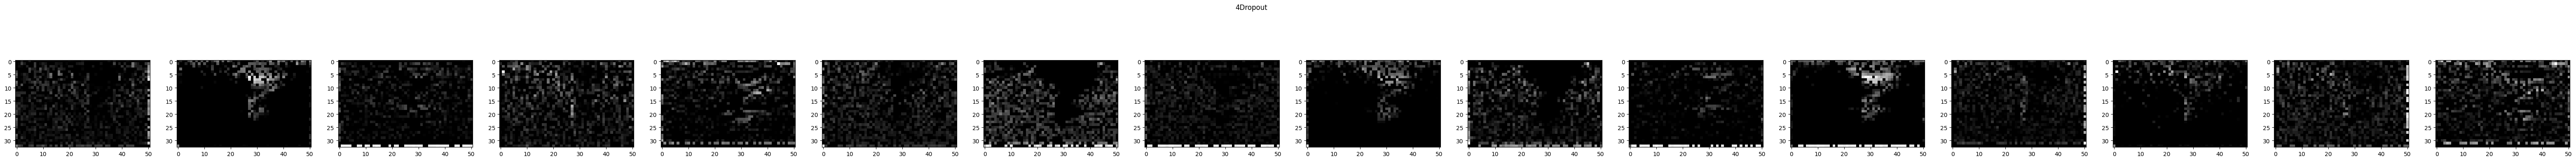

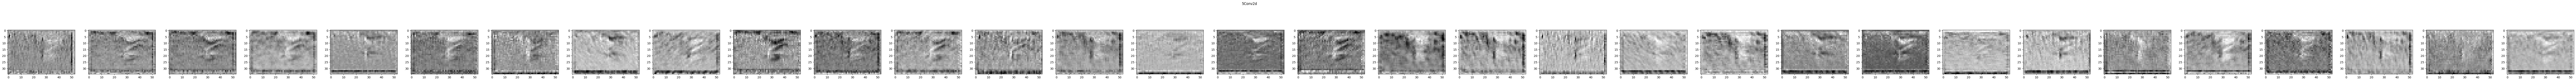

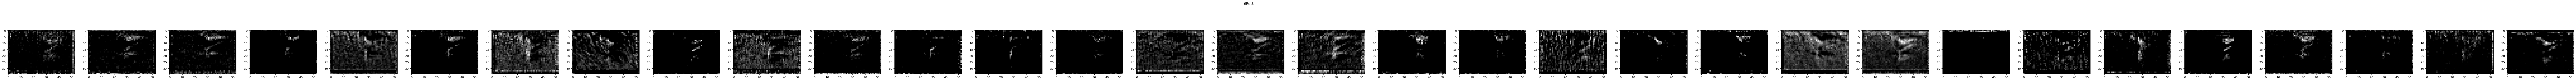

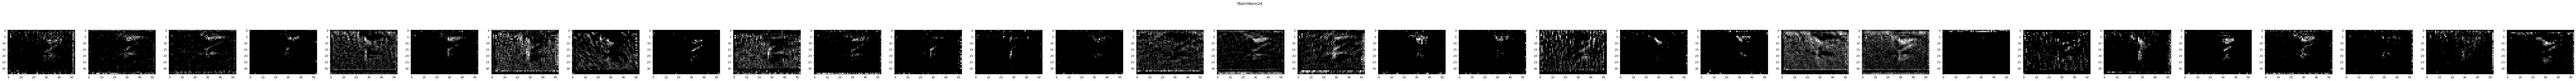

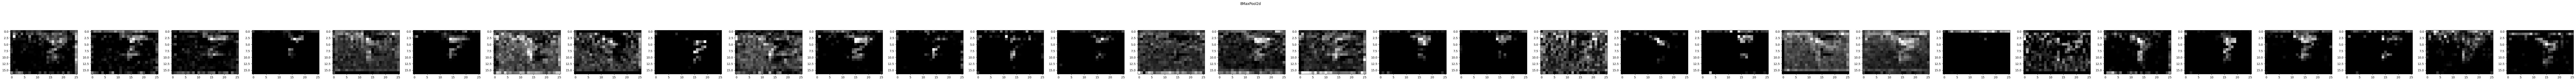

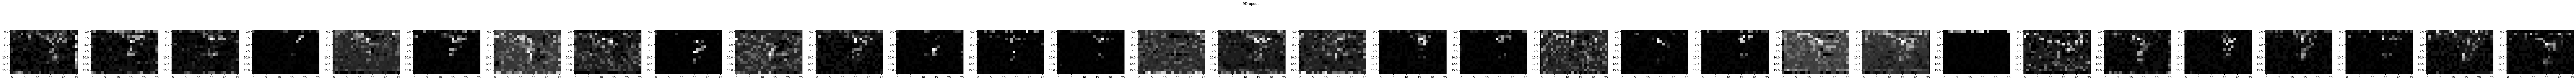

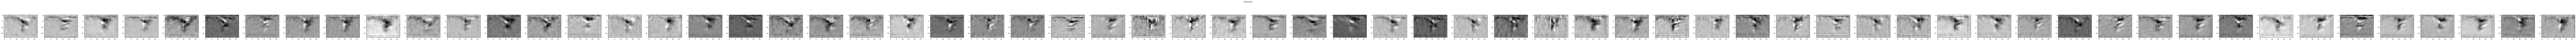

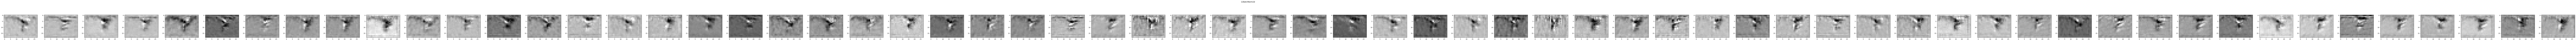

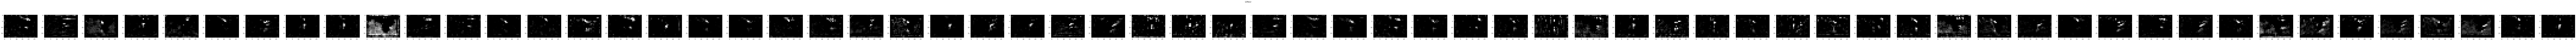

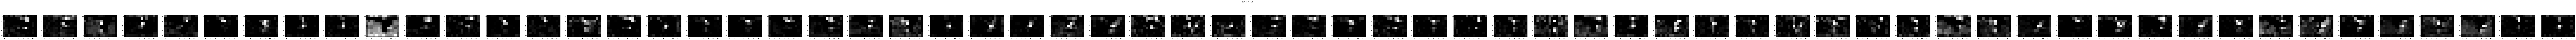

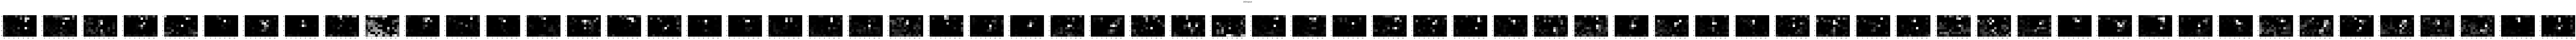

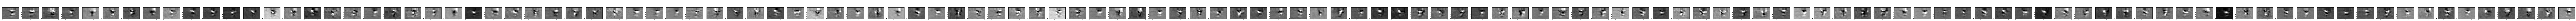

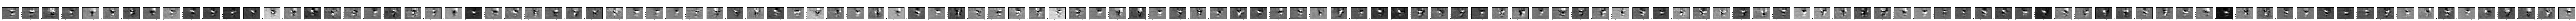

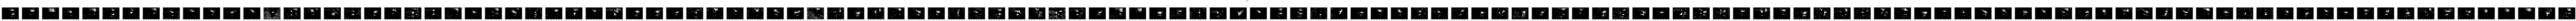

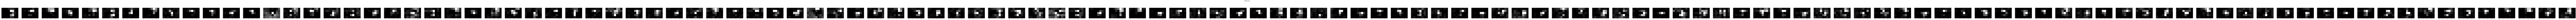

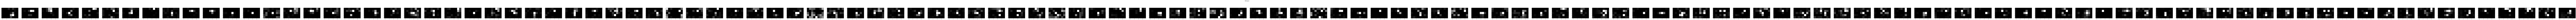

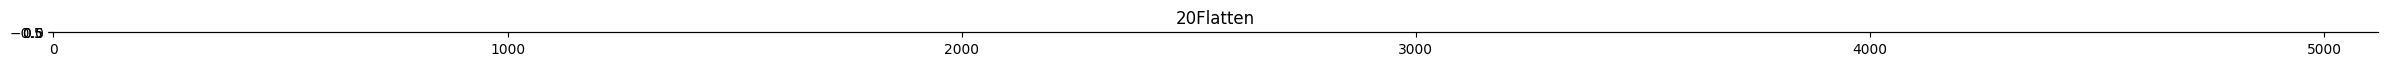

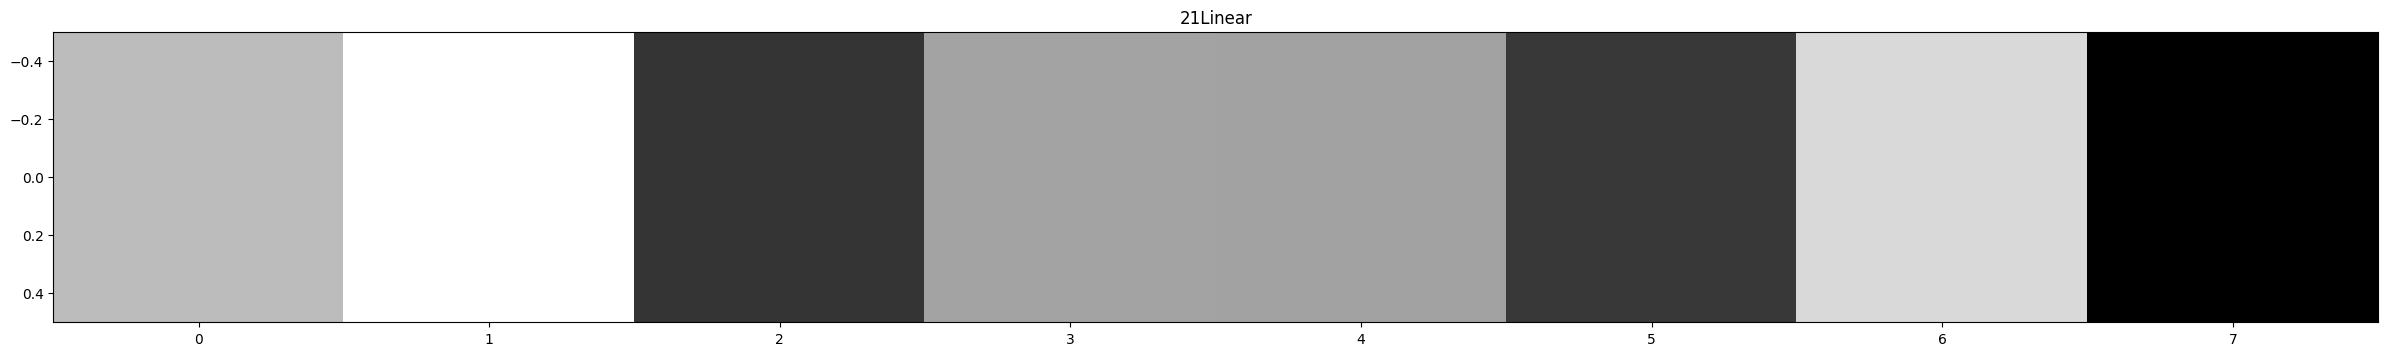

In [146]:
for name in features.keys():
    tensor = features[name].squeeze()
    if len(tensor.shape) > 1:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(tensor.shape[0]*5, 5))
        axes = axes.flatten()
        fig.suptitle(name)
        for ax, conv_val in zip(axes, tensor):
            ax.imshow(conv_val.cpu().detach(), cmap='gray')
    else:
        plt.figure(figsize=(30, 5))
        plt.title(name)
        plt.imshow(tensor[None, :].cpu().detach(), cmap='gray')